In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = 'FNN-Classification-Simple'

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b10','b25','b50','b75'],'fi':['targets','roi','brain']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.0001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_1024_512_256_128_00001_CCE_10_1_0_0_1_0_e_e_0_1_0_basal_seg_data_norm_e_k5_b25_t1_0_42_n_native_08_0_05_n


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(923395, 92)
(923395, 3)
validation
(158485, 92)
(158485, 3)
test
(114144, 92)
(114144, 3)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 92)]              0         


 dense (Dense)               (None, 1024)              95232     


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 784643 (2.99 MB)


Trainable params: 784643 (2.99 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


 1/10 [==>...........................] - ETA: 1:00 - loss: 1.1233 - STD: 0.1311 - MAE: 0.4345

 2/10 [=====>........................] - ETA: 0s - loss: 1.1151 - STD: 0.1215 - MAE: 0.4347  

 3/10 [========>.....................] - ETA: 0s - loss: 1.1076 - STD: 0.1127 - MAE: 0.4347

 4/10 [===========>..................] - ETA: 0s - loss: 1.1016 - STD: 0.1050 - MAE: 0.4348

 5/10 [==============>...............] - ETA: 0s - loss: 1.0969 - STD: 0.0987 - MAE: 0.4348

 6/10 [=================>............] - ETA: 0s - loss: 1.0936 - STD: 0.0940 - MAE: 0.4348

 7/10 [====================>.........] - ETA: 0s - loss: 1.0913 - STD: 0.0909 - MAE: 0.4348

 8/10 [=======================>......] - ETA: 0s - loss: 1.0910 - STD: 0.0888 - MAE: 0.4349

 9/10 [==========================>...] - ETA: 0s - loss: 1.0897 - STD: 0.0874 - MAE: 0.4349

10/10 [==============================] - ETA: 0s - loss: 1.0889 - STD: 0.0864 - MAE: 0.4349

10/10 [==============================] - 12s 635ms/step - loss: 1.0889 - STD: 0.0864 - MAE: 0.4349 - val_loss: 1.1042 - val_STD: 0.0777 - val_MAE: 0.4403


Epoch 2/10000


 1/10 [==>...........................] - ETA: 1s - loss: 1.0845 - STD: 0.0777 - MAE: 0.4355

 2/10 [=====>........................] - ETA: 0s - loss: 1.0844 - STD: 0.0772 - MAE: 0.4356

 3/10 [========>.....................] - ETA: 0s - loss: 1.0837 - STD: 0.0763 - MAE: 0.4355

 5/10 [==============>...............] - ETA: 0s - loss: 1.0829 - STD: 0.0742 - MAE: 0.4356

 6/10 [=================>............] - ETA: 0s - loss: 1.0821 - STD: 0.0731 - MAE: 0.4357

 7/10 [====================>.........] - ETA: 0s - loss: 1.0811 - STD: 0.0721 - MAE: 0.4356

 8/10 [=======================>......] - ETA: 0s - loss: 1.0806 - STD: 0.0713 - MAE: 0.4356

 9/10 [==========================>...] - ETA: 0s - loss: 1.0801 - STD: 0.0708 - MAE: 0.4356

10/10 [==============================] - ETA: 0s - loss: 1.0797 - STD: 0.0705 - MAE: 0.4355

10/10 [==============================] - 2s 149ms/step - loss: 1.0797 - STD: 0.0705 - MAE: 0.4355 - val_loss: 1.0834 - val_STD: 0.0695 - val_MAE: 0.4364


Epoch 3/10000


 1/10 [==>...........................] - ETA: 1s - loss: 1.0766 - STD: 0.0696 - MAE: 0.4349

 2/10 [=====>........................] - ETA: 0s - loss: 1.0770 - STD: 0.0705 - MAE: 0.4349

 3/10 [========>.....................] - ETA: 0s - loss: 1.0768 - STD: 0.0712 - MAE: 0.4347

 4/10 [===========>..................] - ETA: 0s - loss: 1.0769 - STD: 0.0719 - MAE: 0.4347

 5/10 [==============>...............] - ETA: 0s - loss: 1.0771 - STD: 0.0725 - MAE: 0.4346

 6/10 [=================>............] - ETA: 0s - loss: 1.0772 - STD: 0.0728 - MAE: 0.4346

 7/10 [====================>.........] - ETA: 0s - loss: 1.0773 - STD: 0.0730 - MAE: 0.4346

 8/10 [=======================>......] - ETA: 0s - loss: 1.0773 - STD: 0.0730 - MAE: 0.4346

 9/10 [==========================>...] - ETA: 0s - loss: 1.0772 - STD: 0.0729 - MAE: 0.4346

10/10 [==============================] - 1s 117ms/step - loss: 1.0773 - STD: 0.0727 - MAE: 0.4346 - val_loss: 1.0839 - val_STD: 0.0688 - val_MAE: 0.4367


Epoch 4/10000


 1/10 [==>...........................] - ETA: 1s - loss: 1.0758 - STD: 0.0689 - MAE: 0.4348

 2/10 [=====>........................] - ETA: 0s - loss: 1.0763 - STD: 0.0682 - MAE: 0.4350

 3/10 [========>.....................] - ETA: 0s - loss: 1.0762 - STD: 0.0677 - MAE: 0.4351

 4/10 [===========>..................] - ETA: 0s - loss: 1.0763 - STD: 0.0673 - MAE: 0.4351

 5/10 [==============>...............] - ETA: 0s - loss: 1.0762 - STD: 0.0669 - MAE: 0.4352

 6/10 [=================>............] - ETA: 0s - loss: 1.0761 - STD: 0.0667 - MAE: 0.4352

 8/10 [=======================>......] - ETA: 0s - loss: 1.0761 - STD: 0.0666 - MAE: 0.4352

 9/10 [==========================>...] - ETA: 0s - loss: 1.0760 - STD: 0.0667 - MAE: 0.4351

10/10 [==============================] - ETA: 0s - loss: 1.0759 - STD: 0.0669 - MAE: 0.4351

10/10 [==============================] - 1s 106ms/step - loss: 1.0759 - STD: 0.0669 - MAE: 0.4351 - val_loss: 1.0880 - val_STD: 0.0689 - val_MAE: 0.4377


Epoch 5/10000


 1/10 [==>...........................] - ETA: 0s - loss: 1.0766 - STD: 0.0690 - MAE: 0.4350

 2/10 [=====>........................] - ETA: 1s - loss: 1.0746 - STD: 0.0692 - MAE: 0.4347

 3/10 [========>.....................] - ETA: 0s - loss: 1.0755 - STD: 0.0694 - MAE: 0.4347

 4/10 [===========>..................] - ETA: 0s - loss: 1.0752 - STD: 0.0695 - MAE: 0.4347

 5/10 [==============>...............] - ETA: 0s - loss: 1.0754 - STD: 0.0695 - MAE: 0.4347

 6/10 [=================>............] - ETA: 0s - loss: 1.0753 - STD: 0.0695 - MAE: 0.4347

 7/10 [====================>.........] - ETA: 0s - loss: 1.0753 - STD: 0.0695 - MAE: 0.4347

 8/10 [=======================>......] - ETA: 0s - loss: 1.0753 - STD: 0.0694 - MAE: 0.4347

 9/10 [==========================>...] - ETA: 0s - loss: 1.0753 - STD: 0.0693 - MAE: 0.4347

10/10 [==============================] - ETA: 0s - loss: 1.0754 - STD: 0.0692 - MAE: 0.4347

10/10 [==============================] - 1s 139ms/step - loss: 1.0754 - STD: 0.0692 - MAE: 0.4347 - val_loss: 1.0832 - val_STD: 0.0680 - val_MAE: 0.4366


Epoch 6/10000


 1/10 [==>...........................] - ETA: 2s - loss: 1.0753 - STD: 0.0681 - MAE: 0.4348

 2/10 [=====>........................] - ETA: 0s - loss: 1.0758 - STD: 0.0679 - MAE: 0.4349

 3/10 [========>.....................] - ETA: 0s - loss: 1.0753 - STD: 0.0678 - MAE: 0.4348

 4/10 [===========>..................] - ETA: 0s - loss: 1.0753 - STD: 0.0677 - MAE: 0.4348

 5/10 [==============>...............] - ETA: 0s - loss: 1.0753 - STD: 0.0677 - MAE: 0.4348

 6/10 [=================>............] - ETA: 0s - loss: 1.0752 - STD: 0.0677 - MAE: 0.4348

 7/10 [====================>.........] - ETA: 0s - loss: 1.0751 - STD: 0.0678 - MAE: 0.4348

 8/10 [=======================>......] - ETA: 0s - loss: 1.0750 - STD: 0.0679 - MAE: 0.4348

10/10 [==============================] - ETA: 0s - loss: 1.0749 - STD: 0.0681 - MAE: 0.4347

10/10 [==============================] - 1s 118ms/step - loss: 1.0749 - STD: 0.0681 - MAE: 0.4347 - val_loss: 1.0860 - val_STD: 0.0694 - val_MAE: 0.4372


Epoch 7/10000


 1/10 [==>...........................] - ETA: 2s - loss: 1.0729 - STD: 0.0696 - MAE: 0.4341

 2/10 [=====>........................] - ETA: 0s - loss: 1.0744 - STD: 0.0698 - MAE: 0.4343

 3/10 [========>.....................] - ETA: 0s - loss: 1.0743 - STD: 0.0698 - MAE: 0.4343

 4/10 [===========>..................] - ETA: 0s - loss: 1.0746 - STD: 0.0697 - MAE: 0.4344

 5/10 [==============>...............] - ETA: 0s - loss: 1.0744 - STD: 0.0695 - MAE: 0.4344

 6/10 [=================>............] - ETA: 0s - loss: 1.0745 - STD: 0.0692 - MAE: 0.4344

 7/10 [====================>.........] - ETA: 0s - loss: 1.0744 - STD: 0.0689 - MAE: 0.4345

 8/10 [=======================>......] - ETA: 0s - loss: 1.0743 - STD: 0.0687 - MAE: 0.4345

10/10 [==============================] - ETA: 0s - loss: 1.0743 - STD: 0.0683 - MAE: 0.4345

10/10 [==============================] - 1s 112ms/step - loss: 1.0743 - STD: 0.0683 - MAE: 0.4345 - val_loss: 1.0837 - val_STD: 0.0678 - val_MAE: 0.4368


Epoch 8/10000


 1/10 [==>...........................] - ETA: 2s - loss: 1.0742 - STD: 0.0679 - MAE: 0.4345

 2/10 [=====>........................] - ETA: 0s - loss: 1.0741 - STD: 0.0682 - MAE: 0.4345

 3/10 [========>.....................] - ETA: 0s - loss: 1.0740 - STD: 0.0685 - MAE: 0.4344

 4/10 [===========>..................] - ETA: 0s - loss: 1.0737 - STD: 0.0687 - MAE: 0.4343

 5/10 [==============>...............] - ETA: 0s - loss: 1.0738 - STD: 0.0688 - MAE: 0.4343

 6/10 [=================>............] - ETA: 0s - loss: 1.0737 - STD: 0.0689 - MAE: 0.4343

 7/10 [====================>.........] - ETA: 0s - loss: 1.0737 - STD: 0.0690 - MAE: 0.4343

 8/10 [=======================>......] - ETA: 0s - loss: 1.0737 - STD: 0.0690 - MAE: 0.4343

 9/10 [==========================>...] - ETA: 0s - loss: 1.0736 - STD: 0.0689 - MAE: 0.4343

10/10 [==============================] - ETA: 0s - loss: 1.0735 - STD: 0.0688 - MAE: 0.4343

10/10 [==============================] - 1s 119ms/step - loss: 1.0735 - STD: 0.0688 - MAE: 0.4343 - val_loss: 1.0840 - val_STD: 0.0674 - val_MAE: 0.4369


Epoch 9/10000


 1/10 [==>...........................] - ETA: 1s - loss: 1.0733 - STD: 0.0676 - MAE: 0.4344

 2/10 [=====>........................] - ETA: 0s - loss: 1.0733 - STD: 0.0675 - MAE: 0.4344

 3/10 [========>.....................] - ETA: 0s - loss: 1.0730 - STD: 0.0675 - MAE: 0.4343

 4/10 [===========>..................] - ETA: 0s - loss: 1.0730 - STD: 0.0675 - MAE: 0.4343

 6/10 [=================>............] - ETA: 0s - loss: 1.0732 - STD: 0.0675 - MAE: 0.4344

 7/10 [====================>.........] - ETA: 0s - loss: 1.0730 - STD: 0.0674 - MAE: 0.4344

 8/10 [=======================>......] - ETA: 0s - loss: 1.0728 - STD: 0.0673 - MAE: 0.4343

 9/10 [==========================>...] - ETA: 0s - loss: 1.0727 - STD: 0.0673 - MAE: 0.4343

10/10 [==============================] - ETA: 0s - loss: 1.0726 - STD: 0.0673 - MAE: 0.4343

10/10 [==============================] - 1s 122ms/step - loss: 1.0726 - STD: 0.0673 - MAE: 0.4343 - val_loss: 1.0836 - val_STD: 0.0681 - val_MAE: 0.4367


Epoch 10/10000


 1/10 [==>...........................] - ETA: 1s - loss: 1.0709 - STD: 0.0684 - MAE: 0.4337

 2/10 [=====>........................] - ETA: 0s - loss: 1.0709 - STD: 0.0689 - MAE: 0.4337

 3/10 [========>.....................] - ETA: 0s - loss: 1.0717 - STD: 0.0693 - MAE: 0.4337

 4/10 [===========>..................] - ETA: 0s - loss: 1.0715 - STD: 0.0696 - MAE: 0.4336

 5/10 [==============>...............] - ETA: 0s - loss: 1.0715 - STD: 0.0697 - MAE: 0.4336

 6/10 [=================>............] - ETA: 0s - loss: 1.0715 - STD: 0.0697 - MAE: 0.4336

 7/10 [====================>.........] - ETA: 0s - loss: 1.0714 - STD: 0.0696 - MAE: 0.4336

 8/10 [=======================>......] - ETA: 0s - loss: 1.0713 - STD: 0.0694 - MAE: 0.4336

 9/10 [==========================>...] - ETA: 0s - loss: 1.0714 - STD: 0.0693 - MAE: 0.4337

10/10 [==============================] - ETA: 0s - loss: 1.0713 - STD: 0.0691 - MAE: 0.4337

10/10 [==============================] - 1s 121ms/step - loss: 1.0713 - STD: 0.0691 - MAE: 0.4337 - val_loss: 1.0824 - val_STD: 0.0664 - val_MAE: 0.4367


Epoch 11/10000


 1/10 [==>...........................] - ETA: 2s - loss: 1.0698 - STD: 0.0668 - MAE: 0.4336

 2/10 [=====>........................] - ETA: 0s - loss: 1.0705 - STD: 0.0669 - MAE: 0.4338

 3/10 [========>.....................] - ETA: 0s - loss: 1.0703 - STD: 0.0670 - MAE: 0.4337

 4/10 [===========>..................] - ETA: 0s - loss: 1.0702 - STD: 0.0672 - MAE: 0.4337

 5/10 [==============>...............] - ETA: 0s - loss: 1.0701 - STD: 0.0674 - MAE: 0.4336

 6/10 [=================>............] - ETA: 0s - loss: 1.0701 - STD: 0.0676 - MAE: 0.4336

 7/10 [====================>.........] - ETA: 0s - loss: 1.0700 - STD: 0.0678 - MAE: 0.4335

 8/10 [=======================>......] - ETA: 0s - loss: 1.0699 - STD: 0.0679 - MAE: 0.4335

 9/10 [==========================>...] - ETA: 0s - loss: 1.0697 - STD: 0.0680 - MAE: 0.4334

10/10 [==============================] - 1s 129ms/step - loss: 1.0697 - STD: 0.0681 - MAE: 0.4334 - val_loss: 1.0816 - val_STD: 0.0677 - val_MAE: 0.4363


Epoch 12/10000


 1/10 [==>...........................] - ETA: 1s - loss: 1.0682 - STD: 0.0682 - MAE: 0.4330

 2/10 [=====>........................] - ETA: 0s - loss: 1.0681 - STD: 0.0681 - MAE: 0.4330

 3/10 [========>.....................] - ETA: 0s - loss: 1.0677 - STD: 0.0680 - MAE: 0.4329

 4/10 [===========>..................] - ETA: 0s - loss: 1.0677 - STD: 0.0681 - MAE: 0.4329

 5/10 [==============>...............] - ETA: 0s - loss: 1.0675 - STD: 0.0682 - MAE: 0.4328

 6/10 [=================>............] - ETA: 0s - loss: 1.0677 - STD: 0.0684 - MAE: 0.4328

 8/10 [=======================>......] - ETA: 0s - loss: 1.0675 - STD: 0.0686 - MAE: 0.4328

 9/10 [==========================>...] - ETA: 0s - loss: 1.0674 - STD: 0.0685 - MAE: 0.4327

10/10 [==============================] - ETA: 0s - loss: 1.0673 - STD: 0.0685 - MAE: 0.4327

10/10 [==============================] - 1s 134ms/step - loss: 1.0673 - STD: 0.0685 - MAE: 0.4327 - val_loss: 1.0801 - val_STD: 0.0667 - val_MAE: 0.4361


Epoch 13/10000


 1/10 [==>...........................] - ETA: 2s - loss: 1.0663 - STD: 0.0674 - MAE: 0.4326

 2/10 [=====>........................] - ETA: 0s - loss: 1.0656 - STD: 0.0672 - MAE: 0.4325

 3/10 [========>.....................] - ETA: 0s - loss: 1.0652 - STD: 0.0671 - MAE: 0.4324

 4/10 [===========>..................] - ETA: 0s - loss: 1.0650 - STD: 0.0673 - MAE: 0.4323

 5/10 [==============>...............] - ETA: 0s - loss: 1.0649 - STD: 0.0675 - MAE: 0.4323

 6/10 [=================>............] - ETA: 0s - loss: 1.0648 - STD: 0.0678 - MAE: 0.4321

 7/10 [====================>.........] - ETA: 0s - loss: 1.0645 - STD: 0.0682 - MAE: 0.4320

 8/10 [=======================>......] - ETA: 0s - loss: 1.0642 - STD: 0.0685 - MAE: 0.4319

 9/10 [==========================>...] - ETA: 0s - loss: 1.0640 - STD: 0.0688 - MAE: 0.4318

10/10 [==============================] - ETA: 0s - loss: 1.0637 - STD: 0.0689 - MAE: 0.4317

10/10 [==============================] - 1s 140ms/step - loss: 1.0637 - STD: 0.0689 - MAE: 0.4317 - val_loss: 1.0781 - val_STD: 0.0686 - val_MAE: 0.4354


Epoch 14/10000


 1/10 [==>...........................] - ETA: 2s - loss: 1.0603 - STD: 0.0695 - MAE: 0.4309

 2/10 [=====>........................] - ETA: 0s - loss: 1.0603 - STD: 0.0693 - MAE: 0.4309

 3/10 [========>.....................] - ETA: 0s - loss: 1.0605 - STD: 0.0691 - MAE: 0.4310

 4/10 [===========>..................] - ETA: 0s - loss: 1.0604 - STD: 0.0690 - MAE: 0.4309

 5/10 [==============>...............] - ETA: 0s - loss: 1.0601 - STD: 0.0689 - MAE: 0.4309

 7/10 [====================>.........] - ETA: 0s - loss: 1.0596 - STD: 0.0688 - MAE: 0.4307

 8/10 [=======================>......] - ETA: 0s - loss: 1.0592 - STD: 0.0688 - MAE: 0.4307

 9/10 [==========================>...] - ETA: 0s - loss: 1.0588 - STD: 0.0690 - MAE: 0.4305

10/10 [==============================] - ETA: 0s - loss: 1.0585 - STD: 0.0692 - MAE: 0.4304

10/10 [==============================] - 2s 144ms/step - loss: 1.0585 - STD: 0.0692 - MAE: 0.4304 - val_loss: 1.0757 - val_STD: 0.0699 - val_MAE: 0.4347


Epoch 15/10000


 1/10 [==>...........................] - ETA: 1s - loss: 1.0548 - STD: 0.0711 - MAE: 0.4292

 2/10 [=====>........................] - ETA: 0s - loss: 1.0549 - STD: 0.0710 - MAE: 0.4292

 3/10 [========>.....................] - ETA: 0s - loss: 1.0540 - STD: 0.0707 - MAE: 0.4291

 5/10 [==============>...............] - ETA: 0s - loss: 1.0533 - STD: 0.0703 - MAE: 0.4289

 6/10 [=================>............] - ETA: 0s - loss: 1.0526 - STD: 0.0702 - MAE: 0.4288

 7/10 [====================>.........] - ETA: 0s - loss: 1.0522 - STD: 0.0704 - MAE: 0.4287

 8/10 [=======================>......] - ETA: 0s - loss: 1.0517 - STD: 0.0705 - MAE: 0.4285

 9/10 [==========================>...] - ETA: 0s - loss: 1.0511 - STD: 0.0707 - MAE: 0.4284

10/10 [==============================] - ETA: 0s - loss: 1.0505 - STD: 0.0710 - MAE: 0.4282

10/10 [==============================] - 1s 137ms/step - loss: 1.0505 - STD: 0.0710 - MAE: 0.4282 - val_loss: 1.0712 - val_STD: 0.0722 - val_MAE: 0.4334


Epoch 16/10000


 1/10 [==>...........................] - ETA: 1s - loss: 1.0446 - STD: 0.0738 - MAE: 0.4263

 2/10 [=====>........................] - ETA: 0s - loss: 1.0440 - STD: 0.0740 - MAE: 0.4261

 3/10 [========>.....................] - ETA: 0s - loss: 1.0434 - STD: 0.0741 - MAE: 0.4259

 4/10 [===========>..................] - ETA: 0s - loss: 1.0431 - STD: 0.0742 - MAE: 0.4258

 5/10 [==============>...............] - ETA: 0s - loss: 1.0422 - STD: 0.0741 - MAE: 0.4256

 6/10 [=================>............] - ETA: 0s - loss: 1.0417 - STD: 0.0741 - MAE: 0.4255

 7/10 [====================>.........] - ETA: 0s - loss: 1.0410 - STD: 0.0740 - MAE: 0.4254

 9/10 [==========================>...] - ETA: 0s - loss: 1.0399 - STD: 0.0742 - MAE: 0.4250

10/10 [==============================] - ETA: 0s - loss: 1.0391 - STD: 0.0745 - MAE: 0.4248

10/10 [==============================] - 1s 137ms/step - loss: 1.0391 - STD: 0.0745 - MAE: 0.4248 - val_loss: 1.0657 - val_STD: 0.0763 - val_MAE: 0.4316


Epoch 17/10000


 1/10 [==>...........................] - ETA: 1s - loss: 1.0300 - STD: 0.0781 - MAE: 0.4220

 2/10 [=====>........................] - ETA: 0s - loss: 1.0297 - STD: 0.0787 - MAE: 0.4218

 3/10 [========>.....................] - ETA: 0s - loss: 1.0286 - STD: 0.0792 - MAE: 0.4215

 4/10 [===========>..................] - ETA: 0s - loss: 1.0280 - STD: 0.0796 - MAE: 0.4213

 5/10 [==============>...............] - ETA: 0s - loss: 1.0270 - STD: 0.0798 - MAE: 0.4210

 6/10 [=================>............] - ETA: 0s - loss: 1.0261 - STD: 0.0801 - MAE: 0.4207

 8/10 [=======================>......] - ETA: 0s - loss: 1.0244 - STD: 0.0808 - MAE: 0.4201

 9/10 [==========================>...] - ETA: 0s - loss: 1.0231 - STD: 0.0814 - MAE: 0.4197

10/10 [==============================] - ETA: 0s - loss: 1.0220 - STD: 0.0821 - MAE: 0.4194

10/10 [==============================] - 1s 115ms/step - loss: 1.0220 - STD: 0.0821 - MAE: 0.4194 - val_loss: 1.0604 - val_STD: 0.0882 - val_MAE: 0.4286


Epoch 18/10000


 1/10 [==>...........................] - ETA: 0s - loss: 1.0124 - STD: 0.0896 - MAE: 0.4157

 2/10 [=====>........................] - ETA: 1s - loss: 1.0093 - STD: 0.0901 - MAE: 0.4152

 3/10 [========>.....................] - ETA: 0s - loss: 1.0080 - STD: 0.0905 - MAE: 0.4148

 4/10 [===========>..................] - ETA: 0s - loss: 1.0066 - STD: 0.0909 - MAE: 0.4144

 5/10 [==============>...............] - ETA: 0s - loss: 1.0051 - STD: 0.0914 - MAE: 0.4140

 6/10 [=================>............] - ETA: 0s - loss: 1.0040 - STD: 0.0920 - MAE: 0.4136

 7/10 [====================>.........] - ETA: 0s - loss: 1.0026 - STD: 0.0928 - MAE: 0.4132

 8/10 [=======================>......] - ETA: 0s - loss: 1.0012 - STD: 0.0937 - MAE: 0.4127

 9/10 [==========================>...] - ETA: 0s - loss: 0.9997 - STD: 0.0946 - MAE: 0.4121

10/10 [==============================] - ETA: 0s - loss: 0.9984 - STD: 0.0956 - MAE: 0.4116

10/10 [==============================] - 1s 140ms/step - loss: 0.9984 - STD: 0.0956 - MAE: 0.4116 - val_loss: 1.0587 - val_STD: 0.1069 - val_MAE: 0.4249


Epoch 19/10000


 1/10 [==>...........................] - ETA: 2s - loss: 0.9844 - STD: 0.1078 - MAE: 0.4057

 2/10 [=====>........................] - ETA: 0s - loss: 0.9843 - STD: 0.1091 - MAE: 0.4053

 3/10 [========>.....................] - ETA: 0s - loss: 0.9831 - STD: 0.1102 - MAE: 0.4048

 4/10 [===========>..................] - ETA: 0s - loss: 0.9817 - STD: 0.1109 - MAE: 0.4044

 5/10 [==============>...............] - ETA: 0s - loss: 0.9802 - STD: 0.1118 - MAE: 0.4038

 6/10 [=================>............] - ETA: 0s - loss: 0.9790 - STD: 0.1129 - MAE: 0.4033

 7/10 [====================>.........] - ETA: 0s - loss: 0.9776 - STD: 0.1140 - MAE: 0.4028

 8/10 [=======================>......] - ETA: 0s - loss: 0.9765 - STD: 0.1152 - MAE: 0.4023

 9/10 [==========================>...] - ETA: 0s - loss: 0.9754 - STD: 0.1163 - MAE: 0.4018

10/10 [==============================] - ETA: 0s - loss: 0.9752 - STD: 0.1173 - MAE: 0.4013

10/10 [==============================] - 1s 123ms/step - loss: 0.9752 - STD: 0.1173 - MAE: 0.4013 - val_loss: 1.0665 - val_STD: 0.1307 - val_MAE: 0.4212


Epoch 20/10000


 1/10 [==>...........................] - ETA: 2s - loss: 0.9614 - STD: 0.1299 - MAE: 0.3954

 2/10 [=====>........................] - ETA: 0s - loss: 0.9593 - STD: 0.1317 - MAE: 0.3945

 3/10 [========>.....................] - ETA: 0s - loss: 0.9586 - STD: 0.1334 - MAE: 0.3938

 4/10 [===========>..................] - ETA: 0s - loss: 0.9574 - STD: 0.1348 - MAE: 0.3932

 5/10 [==============>...............] - ETA: 0s - loss: 0.9564 - STD: 0.1360 - MAE: 0.3927

 6/10 [=================>............] - ETA: 0s - loss: 0.9555 - STD: 0.1371 - MAE: 0.3922

 7/10 [====================>.........] - ETA: 0s - loss: 0.9544 - STD: 0.1384 - MAE: 0.3916

 8/10 [=======================>......] - ETA: 0s - loss: 0.9537 - STD: 0.1397 - MAE: 0.3911

 9/10 [==========================>...] - ETA: 0s - loss: 0.9528 - STD: 0.1410 - MAE: 0.3905

10/10 [==============================] - 1s 110ms/step - loss: 0.9526 - STD: 0.1420 - MAE: 0.3901 - val_loss: 1.0864 - val_STD: 0.1562 - val_MAE: 0.4178


Epoch 21/10000


 1/10 [==>...........................] - ETA: 1s - loss: 0.9419 - STD: 0.1537 - MAE: 0.3845

 2/10 [=====>........................] - ETA: 0s - loss: 0.9412 - STD: 0.1555 - MAE: 0.3838

 3/10 [========>.....................] - ETA: 0s - loss: 0.9406 - STD: 0.1570 - MAE: 0.3832

 4/10 [===========>..................] - ETA: 0s - loss: 0.9400 - STD: 0.1579 - MAE: 0.3828

 5/10 [==============>...............] - ETA: 0s - loss: 0.9396 - STD: 0.1588 - MAE: 0.3825

 6/10 [=================>............] - ETA: 0s - loss: 0.9391 - STD: 0.1597 - MAE: 0.3821

 8/10 [=======================>......] - ETA: 0s - loss: 0.9381 - STD: 0.1620 - MAE: 0.3810

 9/10 [==========================>...] - ETA: 0s - loss: 0.9375 - STD: 0.1631 - MAE: 0.3806

10/10 [==============================] - ETA: 0s - loss: 0.9367 - STD: 0.1641 - MAE: 0.3801

10/10 [==============================] - 1s 111ms/step - loss: 0.9367 - STD: 0.1641 - MAE: 0.3801 - val_loss: 1.1134 - val_STD: 0.1786 - val_MAE: 0.4152


Epoch 22/10000


 1/10 [==>...........................] - ETA: 2s - loss: 0.9294 - STD: 0.1754 - MAE: 0.3747

 2/10 [=====>........................] - ETA: 1s - loss: 0.9309 - STD: 0.1757 - MAE: 0.3750

 3/10 [========>.....................] - ETA: 0s - loss: 0.9300 - STD: 0.1757 - MAE: 0.3748

 4/10 [===========>..................] - ETA: 0s - loss: 0.9294 - STD: 0.1762 - MAE: 0.3745

 6/10 [=================>............] - ETA: 0s - loss: 0.9295 - STD: 0.1777 - MAE: 0.3740

 7/10 [====================>.........] - ETA: 0s - loss: 0.9289 - STD: 0.1784 - MAE: 0.3736

 8/10 [=======================>......] - ETA: 0s - loss: 0.9282 - STD: 0.1789 - MAE: 0.3733

 9/10 [==========================>...] - ETA: 0s - loss: 0.9278 - STD: 0.1794 - MAE: 0.3730

10/10 [==============================] - ETA: 0s - loss: 0.9274 - STD: 0.1799 - MAE: 0.3728

10/10 [==============================] - 1s 123ms/step - loss: 0.9274 - STD: 0.1799 - MAE: 0.3728 - val_loss: 1.1347 - val_STD: 0.1914 - val_MAE: 0.4139


Epoch 23/10000


 1/10 [==>...........................] - ETA: 1s - loss: 0.9257 - STD: 0.1871 - MAE: 0.3698

 2/10 [=====>........................] - ETA: 1s - loss: 0.9263 - STD: 0.1871 - MAE: 0.3698

 3/10 [========>.....................] - ETA: 0s - loss: 0.9241 - STD: 0.1876 - MAE: 0.3693

 4/10 [===========>..................] - ETA: 0s - loss: 0.9235 - STD: 0.1882 - MAE: 0.3689

 5/10 [==============>...............] - ETA: 0s - loss: 0.9228 - STD: 0.1885 - MAE: 0.3686

 6/10 [=================>............] - ETA: 0s - loss: 0.9227 - STD: 0.1888 - MAE: 0.3685

 7/10 [====================>.........] - ETA: 0s - loss: 0.9222 - STD: 0.1890 - MAE: 0.3683

 8/10 [=======================>......] - ETA: 0s - loss: 0.9220 - STD: 0.1891 - MAE: 0.3682

 9/10 [==========================>...] - ETA: 0s - loss: 0.9214 - STD: 0.1891 - MAE: 0.3681

10/10 [==============================] - ETA: 0s - loss: 0.9210 - STD: 0.1893 - MAE: 0.3679

10/10 [==============================] - 1s 136ms/step - loss: 0.9210 - STD: 0.1893 - MAE: 0.3679 - val_loss: 1.1474 - val_STD: 0.1976 - val_MAE: 0.4133


Epoch 24/10000


 1/10 [==>...........................] - ETA: 0s - loss: 0.9156 - STD: 0.1934 - MAE: 0.3651

 2/10 [=====>........................] - ETA: 1s - loss: 0.9183 - STD: 0.1929 - MAE: 0.3656

 3/10 [========>.....................] - ETA: 0s - loss: 0.9168 - STD: 0.1924 - MAE: 0.3656

 4/10 [===========>..................] - ETA: 0s - loss: 0.9169 - STD: 0.1921 - MAE: 0.3658

 5/10 [==============>...............] - ETA: 0s - loss: 0.9170 - STD: 0.1923 - MAE: 0.3657

 6/10 [=================>............] - ETA: 0s - loss: 0.9167 - STD: 0.1927 - MAE: 0.3655

 7/10 [====================>.........] - ETA: 0s - loss: 0.9166 - STD: 0.1930 - MAE: 0.3654

 8/10 [=======================>......] - ETA: 0s - loss: 0.9164 - STD: 0.1931 - MAE: 0.3653

 9/10 [==========================>...] - ETA: 0s - loss: 0.9161 - STD: 0.1931 - MAE: 0.3653

10/10 [==============================] - ETA: 0s - loss: 0.9159 - STD: 0.1933 - MAE: 0.3652

10/10 [==============================] - 1s 131ms/step - loss: 0.9159 - STD: 0.1933 - MAE: 0.3652 - val_loss: 1.1519 - val_STD: 0.2006 - val_MAE: 0.4126


Epoch 25/10000


 1/10 [==>...........................] - ETA: 0s - loss: 0.9085 - STD: 0.1967 - MAE: 0.3621

 2/10 [=====>........................] - ETA: 1s - loss: 0.9127 - STD: 0.1962 - MAE: 0.3629

 3/10 [========>.....................] - ETA: 0s - loss: 0.9135 - STD: 0.1953 - MAE: 0.3635

 4/10 [===========>..................] - ETA: 0s - loss: 0.9130 - STD: 0.1948 - MAE: 0.3637

 5/10 [==============>...............] - ETA: 0s - loss: 0.9123 - STD: 0.1947 - MAE: 0.3637

 6/10 [=================>............] - ETA: 0s - loss: 0.9126 - STD: 0.1948 - MAE: 0.3637

 7/10 [====================>.........] - ETA: 0s - loss: 0.9124 - STD: 0.1950 - MAE: 0.3636

 8/10 [=======================>......] - ETA: 0s - loss: 0.9118 - STD: 0.1949 - MAE: 0.3635

 9/10 [==========================>...] - ETA: 0s - loss: 0.9116 - STD: 0.1947 - MAE: 0.3636

10/10 [==============================] - ETA: 0s - loss: 0.9113 - STD: 0.1948 - MAE: 0.3635

10/10 [==============================] - 1s 147ms/step - loss: 0.9113 - STD: 0.1948 - MAE: 0.3635 - val_loss: 1.1537 - val_STD: 0.2027 - val_MAE: 0.4118


Epoch 26/10000


 1/10 [==>...........................] - ETA: 1s - loss: 0.9102 - STD: 0.1974 - MAE: 0.3623

 2/10 [=====>........................] - ETA: 0s - loss: 0.9092 - STD: 0.1972 - MAE: 0.3621

 3/10 [========>.....................] - ETA: 0s - loss: 0.9084 - STD: 0.1968 - MAE: 0.3622

 4/10 [===========>..................] - ETA: 0s - loss: 0.9091 - STD: 0.1964 - MAE: 0.3625

 5/10 [==============>...............] - ETA: 0s - loss: 0.9085 - STD: 0.1964 - MAE: 0.3623

 6/10 [=================>............] - ETA: 0s - loss: 0.9078 - STD: 0.1965 - MAE: 0.3621

 8/10 [=======================>......] - ETA: 0s - loss: 0.9079 - STD: 0.1968 - MAE: 0.3621

 9/10 [==========================>...] - ETA: 0s - loss: 0.9074 - STD: 0.1969 - MAE: 0.3619

10/10 [==============================] - ETA: 0s - loss: 0.9072 - STD: 0.1968 - MAE: 0.3619

10/10 [==============================] - 1s 109ms/step - loss: 0.9072 - STD: 0.1968 - MAE: 0.3619 - val_loss: 1.1541 - val_STD: 0.2021 - val_MAE: 0.4115


Epoch 27/10000


 1/10 [==>...........................] - ETA: 1s - loss: 0.9042 - STD: 0.1960 - MAE: 0.3615

 2/10 [=====>........................] - ETA: 0s - loss: 0.9052 - STD: 0.1970 - MAE: 0.3614

 3/10 [========>.....................] - ETA: 0s - loss: 0.9058 - STD: 0.1972 - MAE: 0.3614

 4/10 [===========>..................] - ETA: 0s - loss: 0.9060 - STD: 0.1971 - MAE: 0.3615

 5/10 [==============>...............] - ETA: 0s - loss: 0.9053 - STD: 0.1972 - MAE: 0.3613

 6/10 [=================>............] - ETA: 0s - loss: 0.9048 - STD: 0.1974 - MAE: 0.3611

 7/10 [====================>.........] - ETA: 0s - loss: 0.9041 - STD: 0.1977 - MAE: 0.3609

 8/10 [=======================>......] - ETA: 0s - loss: 0.9038 - STD: 0.1980 - MAE: 0.3607

 9/10 [==========================>...] - ETA: 0s - loss: 0.9035 - STD: 0.1981 - MAE: 0.3606

10/10 [==============================] - 1s 124ms/step - loss: 0.9033 - STD: 0.1982 - MAE: 0.3603 - val_loss: 1.1588 - val_STD: 0.2072 - val_MAE: 0.4101


Epoch 28/10000


 1/10 [==>...........................] - ETA: 2s - loss: 0.9008 - STD: 0.2016 - MAE: 0.3586

 2/10 [=====>........................] - ETA: 0s - loss: 0.9008 - STD: 0.2021 - MAE: 0.3584

 3/10 [========>.....................] - ETA: 0s - loss: 0.9008 - STD: 0.2018 - MAE: 0.3585

 4/10 [===========>..................] - ETA: 0s - loss: 0.9006 - STD: 0.2014 - MAE: 0.3587

 5/10 [==============>...............] - ETA: 0s - loss: 0.9001 - STD: 0.2013 - MAE: 0.3586

 6/10 [=================>............] - ETA: 0s - loss: 0.8997 - STD: 0.2014 - MAE: 0.3585

 7/10 [====================>.........] - ETA: 0s - loss: 0.8995 - STD: 0.2015 - MAE: 0.3584

 8/10 [=======================>......] - ETA: 0s - loss: 0.8996 - STD: 0.2014 - MAE: 0.3584

 9/10 [==========================>...] - ETA: 0s - loss: 0.8996 - STD: 0.2012 - MAE: 0.3585

10/10 [==============================] - 1s 118ms/step - loss: 0.8995 - STD: 0.2011 - MAE: 0.3586 - val_loss: 1.1620 - val_STD: 0.2085 - val_MAE: 0.4094


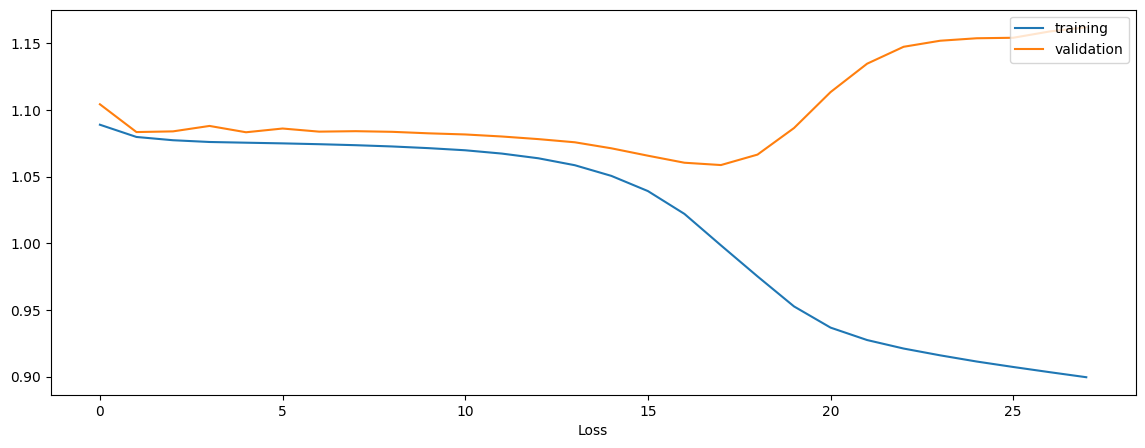

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.5453516642390309


0.4245701485945042


0.5076920381272778


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.672632213955359


0.5217171629179226


0.5674835875990001


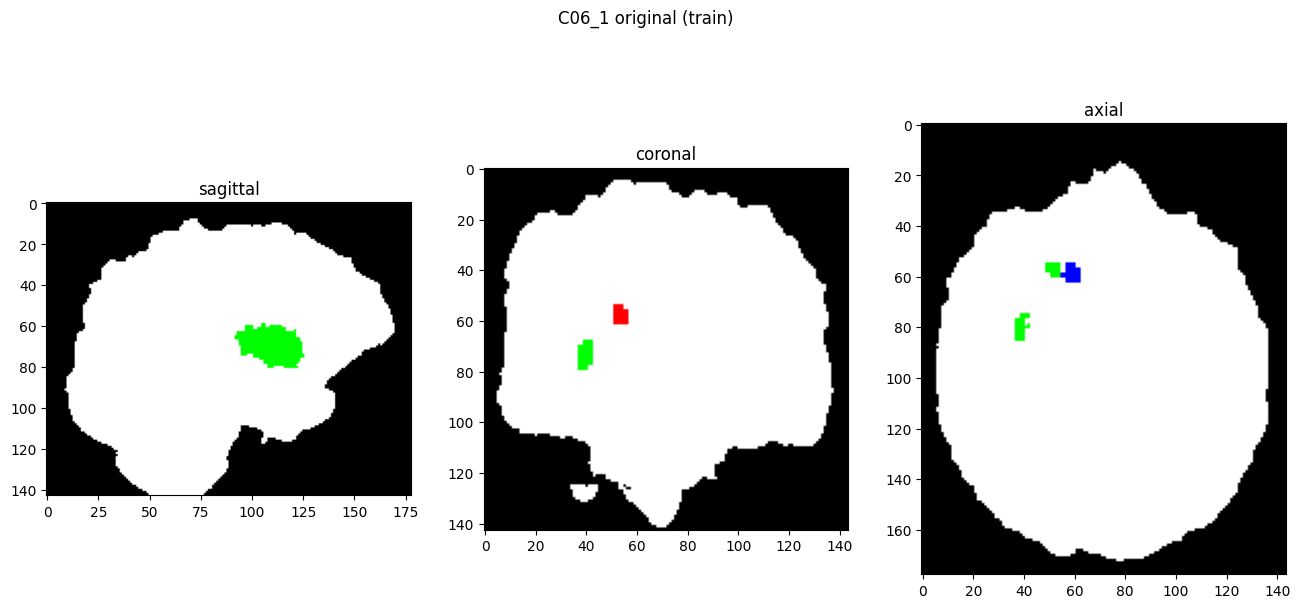

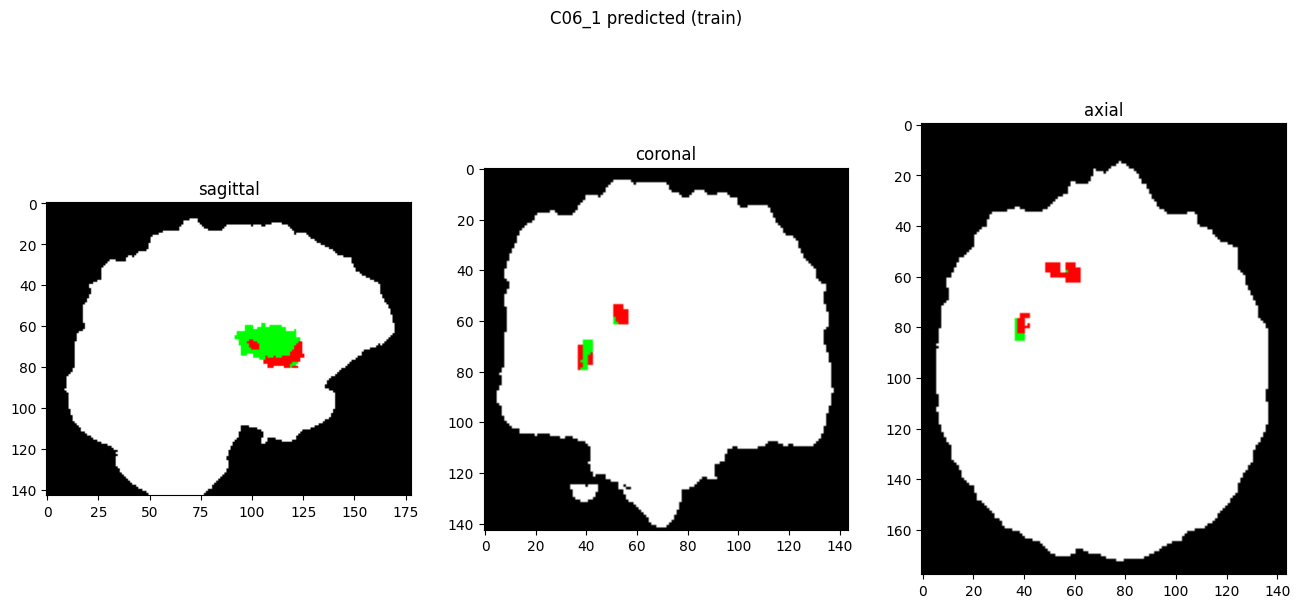

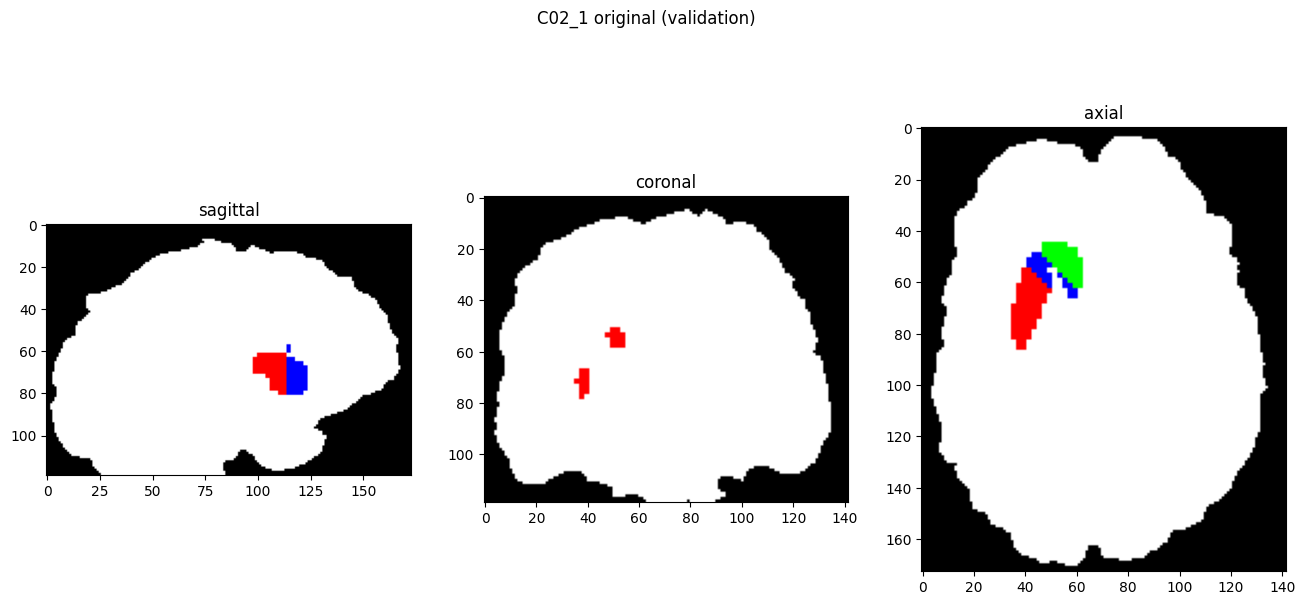

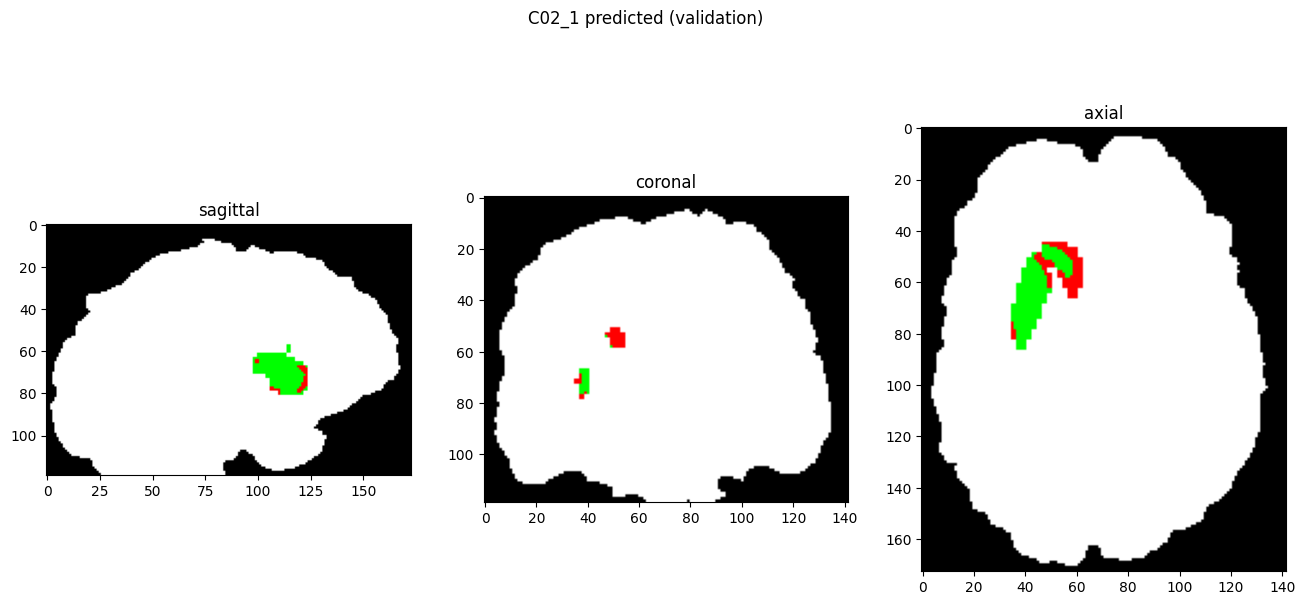

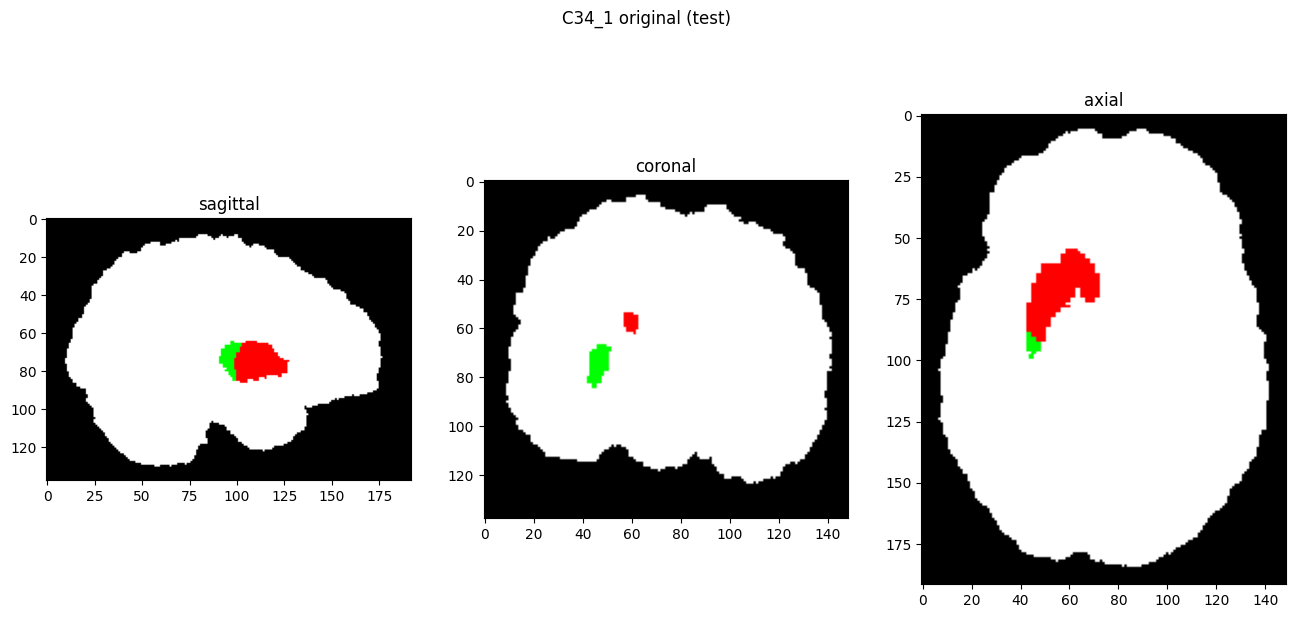

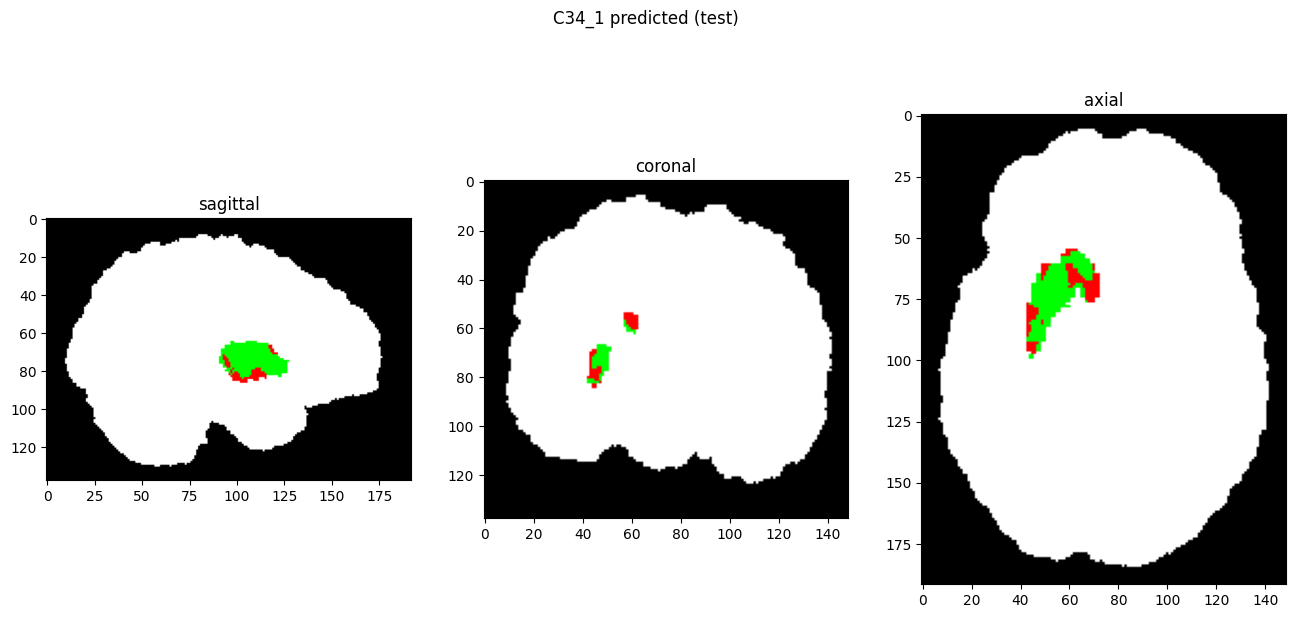

In [9]:
showResults(model, gen, threshold=0)